<a href="https://www.kaggle.com/code/hongyuguo/amp-prot-peptide-network-deeplearning?scriptVersionId=128255138" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-pre

# Part I: Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import RobustScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from keras.layers import Input, Dense, concatenate
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.losses import mean_absolute_percentage_error
import tensorflow as tf
warnings.filterwarnings('ignore')  
%matplotlib inline


In [3]:
dataset_directory = Path('/kaggle/input/amp-parkinsons-disease-progression-prediction')
train_clinical_df = pd.read_csv(dataset_directory / 'train_clinical_data.csv') 
train_peptide_df = pd.read_csv(dataset_directory / 'train_peptides.csv')
train_protein_df = pd.read_csv(dataset_directory / 'train_proteins.csv') 
supp_df = pd.read_csv(dataset_directory / 'supplemental_clinical_data.csv')

In [4]:
train_peptide_df

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [5]:
train_clinical_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [6]:
# # Analysis of the train_clinical_df
# # for each columns in the train_clinical_df, here are the counts of NaN values.
clinical_df = train_clinical_df.copy()
nan_updrs_1 = clinical_df['updrs_1'].isna().sum() 
nan_updrs_2 = clinical_df['updrs_2'].isna().sum()  
nan_updrs_3 = clinical_df['updrs_3'].isna().sum()   
nan_updrs_4 = clinical_df['updrs_4'].isna().sum()  
nan_medical = clinical_df['upd23b_clinical_state_on_medication'].isna().sum()   
print("Train_Clinical_df: \n(Rows, Columns):", clinical_df.shape,"\nNumber of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: \n", nan_updrs_1,nan_updrs_2, nan_updrs_3, nan_updrs_4, nan_medical)
clinical_df = supp_df.copy()
nan_updrs_1 = clinical_df['updrs_1'].isna().sum() 
nan_updrs_2 = clinical_df['updrs_2'].isna().sum()  
nan_updrs_3 = clinical_df['updrs_3'].isna().sum()   
nan_updrs_4 = clinical_df['updrs_4'].isna().sum()  
nan_medical = clinical_df['upd23b_clinical_state_on_medication'].isna().sum()   
print("\nSupplementary_Clinical_df: \n(Rows, Columns):", clinical_df.shape,"\nNumber of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: \n", nan_updrs_1,nan_updrs_2, nan_updrs_3, nan_updrs_4, nan_medical)


Train_Clinical_df: 
(Rows, Columns): (2615, 8) 
Number of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: 
 1 2 25 1038 1327

Supplementary_Clinical_df: 
(Rows, Columns): (2223, 8) 
Number of NAN in updrs_1, updrs_2, updrs_3, updrs_4,medication: 
 213 214 5 928 1101


1. As shown in above, there are 1038/2615 rows in Train_clinical_df have missing values. In order to make use of all the information given in the train_clinical_df, we will use KNN imputation to fill the missing values. 
2. We merge the complete records (no missing values) from Supplementary_clinical_df to Train_clinical_df to augment the clinical dataset aiming to improve the performance of KNN imputation. 
3. Apply x = log (x+1) to transform the data into normal distribution like data. This can also improve the KNN imputation performance. 


## Data cleaning 

1. remove rows with missing values in Supp_df in the specified columns (updrs_1, updrs_2, updrs_3, updrs_4)
2. remove the column 'upd23b_clinical_state_on_medication' from both clinical dataset  as the information is not considered in the test dataset in this competition.

## To analyze the trend in the visit_month column of the DataFrame, we plot a line graph of the average UPDRS scores (i.e., updrs_1, updrs_2, updrs_3, and updrs_4) against the visit_month.

* We can compare the trends of three figures using the cleaned dataset, the cleaned dataset filtered by medication "ON", and the cleaned dataset filtered by medication "OFF".

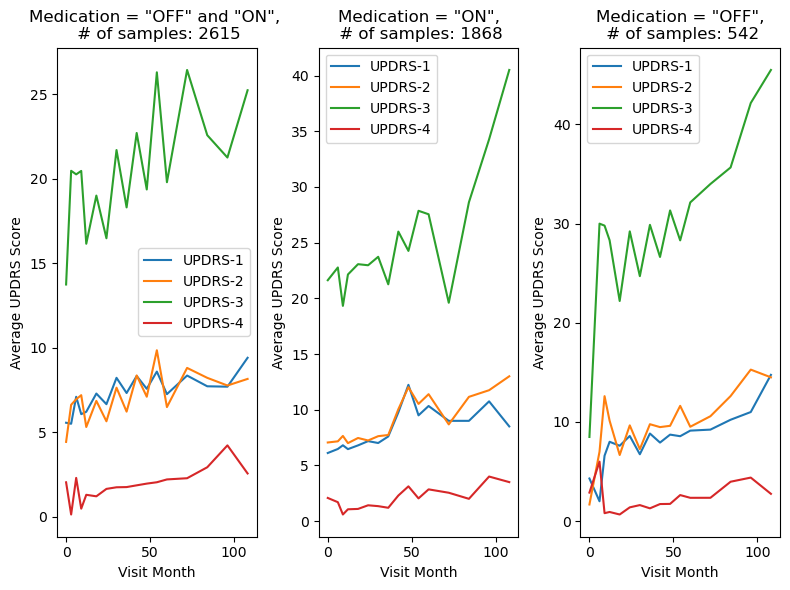

In [7]:
# create three subplots in rows
fig, ax = plt.subplots(ncols = 3,  figsize=(8, 6))

############## the status of "upd23b_clinical_state_on_medication"] is ignored 
# plot the first figure
# read the DataFrame from a file
df = train_clinical_df
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = df.groupby('visit_month').mean()
# plot the line graph of the average UPDRS scores against visit_month
ax[0].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[0].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[0].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[0].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[0].set_xlabel('Visit Month')
ax[0].set_ylabel('Average UPDRS Score')
ax[0].legend()
ax[0].set_title('Medication = "OFF" and "ON", \n # of samples: {}'.format(df.shape[0]))

############## "upd23b_clinical_state_on_medication"] == "On"
# concatenate the two DataFrames vertically
df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
on_medication_df = df[df["upd23b_clinical_state_on_medication"] == "On"]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = on_medication_df.iloc[:, :-1].groupby('visit_month').mean()

# plot the line graph of the average UPDRS scores against visit_month
ax[1].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[1].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[1].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[1].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[1].set_xlabel('Visit Month')
ax[1].legend()
ax[1].set_ylabel('Average UPDRS Score')
ax[1].set_title('Medication = "ON",\n # of samples: {}'.format(on_medication_df.shape[0]))


############## "upd23b_clinical_state_on_medication"] == "Off"
# concatenate the two DataFrames vertically
df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
# Filter df to select only the rows where upd23b_clinical_state_on_medication is 'On'
off_medication_df = df[df["upd23b_clinical_state_on_medication"] == "Off"]
# group the DataFrame by visit_month and calculate the average of UPDRS scores for each group
df_avg = off_medication_df.iloc[:, :-1].groupby('visit_month').mean()

# plot the line graph of the average UPDRS scores against visit_month
ax[2].plot(df_avg.index, df_avg['updrs_1'], label='UPDRS-1')
ax[2].plot(df_avg.index, df_avg['updrs_2'], label='UPDRS-2')
ax[2].plot(df_avg.index, df_avg['updrs_3'], label='UPDRS-3')
ax[2].plot(df_avg.index, df_avg['updrs_4'], label='UPDRS-4')
ax[2].set_xlabel('Visit Month')
ax[2].set_ylabel('Average UPDRS Score')
ax[2].legend()
ax[2].set_title('Medication = "OFF",\n # of samples: {}'.format(off_medication_df.shape[0]))

# adjust the subplots layout
plt.tight_layout()

# show the plot
plt.show()

In [8]:
supp_df.drop(supp_df.columns[-1], axis=1, inplace = True)
train_clinical_df.drop(train_clinical_df.columns[-1],axis=1,inplace = True)
supp_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], inplace=True)
supp_df.shape, train_clinical_df.shape

((1277, 7), (2615, 7))

In [9]:
supp_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,35_0,35,0,5.0,3.0,16.0,0.0
1,35_36,35,36,6.0,4.0,20.0,0.0
2,75_0,75,0,4.0,6.0,26.0,0.0
3,75_36,75,36,1.0,8.0,38.0,0.0
5,337_0,337,0,5.0,7.0,6.0,0.0
...,...,...,...,...,...,...,...
2216,65303_0,65303,0,0.0,2.0,20.0,0.0
2217,65303_36,65303,36,4.0,1.0,26.0,0.0
2219,65405_0,65405,0,5.0,16.0,31.0,0.0
2221,65530_0,65530,0,10.0,6.0,24.0,0.0


In [10]:
# concatenate the two train_clinical_df and supp_df vertically
train_df = pd.concat([train_clinical_df, supp_df], ignore_index=True)

# assume df is your DataFrame
cols_to_normalize = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
# Apply log(1+x) transformation to the last 4 columns
train_df[cols_to_normalize] = np.log1p(train_df[cols_to_normalize])

# perform KNN imputation on the normalized data
imputer = KNNImputer(n_neighbors=15)
# Impute missing values in the last 4 columns
train_df[cols_to_normalize] = imputer.fit_transform(train_df[cols_to_normalize])
#train_df[cols_to_normalize]=round(np.expm1(train_df[cols_to_normalize])) #.astype(int)
train_df[cols_to_normalize]=np.expm1(train_df[cols_to_normalize])
train_df = train_df.head(n= 2615)
train_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,1.495630
1,55_3,55,3,10.0,7.0,25.0,0.791799
2,55_6,55,6,8.0,10.0,34.0,1.295668
3,55_9,55,9,8.0,9.0,30.0,0.000000
4,55_12,55,12,10.0,10.0,41.0,0.000000
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.000000
2611,65043_54,65043,54,4.0,8.0,11.0,1.000000
2612,65043_60,65043,60,6.0,6.0,16.0,1.000000
2613,65043_72,65043,72,3.0,9.0,14.0,1.000000


## Analyze the frequence of visit_month 

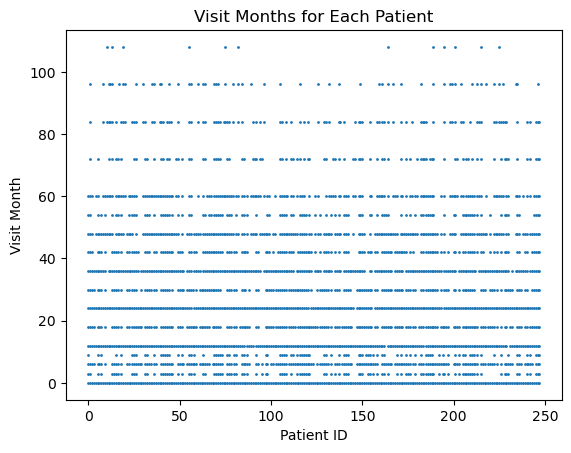

In [11]:
# create a new column with a unique identifier for each patient
df = train_df.copy(deep=True)
df['patient_index'] = df.groupby('patient_id').ngroup()

# create a scatter plot for patient_index versus visit_month
plt.scatter(df['patient_index'], df['visit_month'], s=1)

#plt.scatter(df_new_index.index, df_new_index["visit_month"], s=1)
plt.xlabel("Patient ID")
plt.ylabel("Visit Month")
plt.title("Visit Months for Each Patient")

# display the plot
plt.show()

* In the figure above, the interval between visit_month is approximately 6 months until the 60th month, after which the data becomes sparse. This suggests that only a few patient_id have long-term records beyond 60 months. Therefore, we will focus only on the data from the 60 months prior to the current time period. 
* Since the target of the prediction is from the current time point to 6, 6, 12 months, it would be helpful to include data up to 72 months to gather as much information as possible in our training dataset.

In [12]:
# Part II. Construct time series data

In [13]:
train_df = train_df.rename(columns={
    'updrs_1': 'updrs_1_plus_0_months',
    'updrs_2': 'updrs_2_plus_0_months',
    'updrs_3': 'updrs_3_plus_0_months',
    'updrs_4': 'updrs_4_plus_0_months'
})
train_df

,visit_id,patient_id,visit_month,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months
0,55_0,55,0,10.0,6.0,15.0,1.495630
1,55_3,55,3,10.0,7.0,25.0,0.791799
2,55_6,55,6,8.0,10.0,34.0,1.295668
3,55_9,55,9,8.0,9.0,30.0,0.000000
4,55_12,55,12,10.0,10.0,41.0,0.000000
...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.000000
2611,65043_54,65043,54,4.0,8.0,11.0,1.000000
2612,65043_60,65043,60,6.0,6.0,16.0,1.000000
2613,65043_72,65043,72,3.0,9.0,14.0,1.000000


In [14]:
# define an empty DataFrame with column names
ts_df_updrs = pd.DataFrame(columns=['time', 'patient_id',  'visit_id',
                                    'updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                                    'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                                    'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                                    'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months'
                                    ])

for patient_id in train_df['patient_id'].unique():
    # filter a subset of visiting records for a selected patient_id 
    p_df = train_df[train_df['patient_id']==patient_id]
    ts_start = p_df.visit_month.min()
    ts_end = p_df.visit_month.max()
    ts_span = ts_end - ts_start
    p_num = p_df.shape[0]
    if (p_num > 1) and (ts_span >= 30) and (ts_span/(p_df.shape[0]-1) < 24):
        # the last visit record is 72
        if ts_end > 72:
            ts_end = 72+1

        patient_df = pd.DataFrame({'time': range(ts_start, ts_end, 6), 'patient_id': patient_id})
        # Add the visit_id column
        patient_df['visit_id'] = patient_df['patient_id'].astype(str) + '_' + patient_df['time'].astype(str)
        # merge dataframes on visit_id using left join
        merged_df = pd.merge(patient_df, p_df, on='visit_id', how='left')
        merged_df.drop('patient_id_y', axis=1,inplace = True)
        merged_df.rename(columns={'patient_id_x': 'patient_id'},inplace = True)
        # forward fill missing values
        merged_df = merged_df.fillna(method='ffill')
        # generate new columns updrs_p6_1, updrs_p6_2, updrs_p6_3, updrs_p6_4
        merged_df['updrs_1_plus_6_months'] = merged_df['updrs_1_plus_0_months'].shift(-1)
        merged_df['updrs_2_plus_6_months'] = merged_df['updrs_2_plus_0_months'].shift(-1)
        merged_df['updrs_3_plus_6_months'] = merged_df['updrs_3_plus_0_months'].shift(-1)
        merged_df['updrs_4_plus_6_months'] = merged_df['updrs_4_plus_0_months'].shift(-1)
        merged_df['updrs_1_plus_12_months'] = merged_df['updrs_1_plus_0_months'].shift(-2)
        merged_df['updrs_2_plus_12_months'] = merged_df['updrs_2_plus_0_months'].shift(-2)
        merged_df['updrs_3_plus_12_months'] = merged_df['updrs_3_plus_0_months'].shift(-2)
        merged_df['updrs_4_plus_12_months'] = merged_df['updrs_4_plus_0_months'].shift(-2)
        merged_df['updrs_1_plus_24_months'] = merged_df['updrs_1_plus_0_months'].shift(-4)
        merged_df['updrs_2_plus_24_months'] = merged_df['updrs_2_plus_0_months'].shift(-4)
        merged_df['updrs_3_plus_24_months'] = merged_df['updrs_3_plus_0_months'].shift(-4)
        merged_df['updrs_4_plus_24_months'] = merged_df['updrs_4_plus_0_months'].shift(-4)
    
        merged_df = merged_df.drop('visit_month', axis=1)
        merged_df = merged_df.dropna()
        ts_df_updrs= pd.concat([ts_df_updrs, merged_df],ignore_index=True)
        
        


In [15]:
 ts_df_updrs

,time,patient_id,visit_id,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months,updrs_1_plus_6_months,updrs_2_plus_6_months,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,0,55,55_0,10.0,6.0,15.00000,1.495630,8.0,10.0,34.0,1.295668,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,6,55,55_6,8.0,10.0,34.00000,1.295668,10.0,10.0,41.0,0.000000,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
2,12,55,55_12,10.0,10.0,41.00000,0.000000,7.0,13.0,38.0,0.000000,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
3,18,55,55_18,7.0,13.0,38.00000,0.000000,16.0,9.0,49.0,0.000000,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
4,24,55,55_24,16.0,9.0,49.00000,0.000000,14.0,13.0,49.0,0.000000,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,24,65043,65043_24,4.0,8.0,17.70283,0.000000,3.0,4.0,4.0,0.000000,2.0,7.0,5.0,0.0,7.0,6.0,13.0,0.0
1599,30,65043,65043_30,3.0,4.0,4.00000,0.000000,2.0,7.0,5.0,0.000000,9.0,10.0,15.0,0.0,4.0,8.0,11.0,1.0
1600,36,65043,65043_36,2.0,7.0,5.00000,0.000000,9.0,10.0,15.0,0.000000,7.0,6.0,13.0,0.0,6.0,6.0,16.0,1.0
1601,42,65043,65043_42,9.0,10.0,15.00000,0.000000,7.0,6.0,13.0,0.000000,4.0,8.0,11.0,1.0,6.0,6.0,16.0,1.0


# Part III: Extract features from Proteins and Peptides

## Join Protein and Peptide on 'visit_id','UniProt'

In [16]:
Prot_Peptides_df = pd.merge(train_protein_df, train_peptide_df, on = ['visit_id','UniProt'], how = 'left')
Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','NPX','Peptide','PeptideAbundance']]
Prot_Peptides_df

,visit_id,UniProt,NPX,Peptide,PeptideAbundance
0,55_0,O00391,11254.3,NEQEQPLGQWHLS,11254.30
1,55_0,O00533,732430.0,GNPEPTFSWTK,102060.00
2,55_0,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00
3,55_0,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,O00533,732430.0,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...
981829,58648_108,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00
981830,58648_108,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00
981831,58648_108,Q9Y646,21257.6,LALLVDTVGPR,21257.60
981832,58648_108,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


* check are there NaN values in Prot_Peptides_df

In [17]:
Prot_Peptides_df.isna().sum().sum()

0

* As shown above, there is no Nan in Prot_Peptides_df

## Select a subset of UniProt, which are shared in all visit_id sample.

In [18]:
# group by visit_id and get the set of unique UniProt values for each group
grouped = Prot_Peptides_df.groupby('visit_id')['UniProt'].apply(set)

# calculate the intersection of UniProt values across all groups
intersection = set.intersection(*grouped)

# print the intersection
print(intersection, len(intersection))

{'Q92520', 'P23142', 'P06396', 'P05090', 'P01023', 'P01834', 'P02765', 'P02749', 'O15240', 'Q12805', 'P41222', 'P02774', 'P01009', 'P01042', 'P02647', 'P02751', 'P02790', 'P10909', 'Q9UHG2', 'P02766', 'P01024', 'P01876', 'P01011', 'P02649', 'P02787', 'P07602', 'P02768'} 27


* Among all samples, there are 27 UniProt entries that are present.
* Select the 27 UniProt as features and filter the Prot_Peptides_df to have the intersection. 

In [19]:
# set of UniProt values to select
uniprots_to_select = intersection

# filter the dataframe to select rows with UniProt values in the set
df_filtered = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select)]
# print the resulting dataframe
print(df_filtered)

         visit_id UniProt         NPX          Peptide  PeptideAbundance
15           55_0  O15240    177775.0      AYQGVAAPFPK         107076.00
16           55_0  O15240    177775.0     QQETAAAETETR           3095.35
17           55_0  O15240    177775.0     THLGEALAPLSK          67603.70
94           55_0  P01009  14415900.0          FLENEDR          41501.10
95           55_0  P01009  14415900.0         FLENEDRR          46973.10
...           ...     ...         ...              ...               ...
981797  58648_108  Q92520    907400.0         SPFEQHIK          66357.20
981826  58648_108  Q9UHG2    369437.0     AEAQEAEDQQAR           7884.17
981827  58648_108  Q9UHG2    369437.0   ARAEAQEAEDQQAR          80542.00
981828  58648_108  Q9UHG2    369437.0     GEAAGAVQELAR          78191.40
981829  58648_108  Q9UHG2    369437.0  ILAGSADSEGVAAPR         202820.00

[424373 rows x 5 columns]


## Data preprocessing for 'NPX' and 'PeptideAbundance'
* Since the 'NPX' and 'PeptideAbundance' columns contain large integer features, we apply a logarithmic transformation (log(x+1)) to approximate normality and stabilize their variance. This transformation is commonly used to address skewness in data with a wide range of values. By applying this transformation, the values in these columns are shifted towards zero, resulting in a more symmetric distribution that is characteristic of normal distribution.

* To ensure the transformed values have similar scales, we standardize the data using Z-score normalization on the log-transformed values of the original feature. This step ensures that each feature contributes equally to the analysis, regardless of their original scales.

* Overall, applying log(x+1) to 'NPX' and 'PeptideAbundance' columns and rescaling using Z-score normalization can improve the accuracy and reliability of subsequent analyses.


## Data preprocessing on ['PeptideAbundance']

In [20]:

# apply log(x+1) transformation to columns
df_filtered[['PeptideAbundance']] = df_filtered[['PeptideAbundance']].apply(lambda x: np.log1p(x))

# standardization
scaler1 = StandardScaler()
df_filtered[['PeptideAbundance']] = scaler1.fit_transform(df_filtered[['PeptideAbundance']])


# UniProt-Peptides Network Construction
## For each visit_id, construct a UniProt-Peptides Network with rows represent UniProt and columns represent Peptides.

# Feature extractoin of UniProt-Peptides Network
## Principal component analysis (PCA) is used to extract the most important components of the Protein-Peptides network. These components could then be used as features for downstream analysis

In [21]:
# create a list of all peptides in the original data
all_peptides = df_filtered['Peptide'].unique()
all_visit_id = df_filtered['visit_id'].unique()

pca = PCA(n_components = 10)

# initialize an empty list to store the PCA features
pca_features_list = []

for visit_id in all_visit_id:
    # Part 1: construct UniProt-Peptide Network for each visit_id
    p_df = df_filtered[df_filtered['visit_id'] == visit_id]
    # first, pivot the data so that the UniProt column becomes the index, 
    # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
    pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
    # iterate over each UniProt and add missing peptides as columns with a value of 0
    for prot in pivoted.index:
        missing_peptides = set(all_peptides) - set(pivoted.columns)
        for pep in missing_peptides:
            pivoted.loc[prot, pep] = 0

    # fill any remaining missing values with 0
    pivoted.fillna(0, inplace=True)
    # reset the index so that UniProt is a column again
    pivoted = pivoted.reset_index()
    # rename the index column to 'UniProt'
    pivoted.index.name = 'UniProt'
    # save the pivoted DataFrame to a new variable called `new_df`
    new_df = pivoted.copy(deep=True)
    
    # Part II: PCA feature extraction
    # fit and transform the data
    df1_pca = pca.fit_transform(new_df.iloc[:,1:])
    # flatten the array to one dimension
    df1_pca = np.array(df1_pca).flatten()
    # store the PCA features along with the visit_id in the list
    pca_features_list.append({'visit_id': visit_id, 'pca_features': df1_pca})

# construct a dataframe from the PCA features list
df_pca_features = pd.DataFrame(pca_features_list)
# split the pca_features column into multiple columns
PP_features = pd.concat([df_pca_features.drop('pca_features', axis=1), df_pca_features['pca_features'].apply(pd.Series)], axis=1)

# display the resulting dataframe
print(PP_features)


       visit_id         0         1         2         3         4         5  \
0          55_0 -0.408761 -0.191259 -0.143086 -0.097637 -0.121823 -0.008657   
1        1517_0 -0.390323 -0.207683 -0.223584 -0.037062 -0.226242 -0.162619   
2        1923_0 -0.375939 -0.189745 -0.240332 -0.183197 -0.170522 -0.098476   
3        2660_0 -0.348659 -0.177171 -0.200724 -0.074223 -0.092662 -0.088853   
4        3636_0 -0.366450 -0.188364 -0.165799 -0.269625 -0.250694 -0.115397   
...         ...       ...       ...       ...       ...       ...       ...   
1108   58648_96 -0.375338 -0.090774 -0.171280 -0.221629 -0.094996 -0.008812   
1109   5645_108 -0.420115 -0.094926 -0.274239 -0.107466 -0.152648 -0.184514   
1110  12703_108 -0.335764 -0.160216 -0.159047 -0.013911 -0.230621 -0.141327   
1111  55096_108 -0.414612 -0.076189 -0.264506 -0.266721 -0.201371 -0.251426   
1112  58648_108 -0.371630 -0.114047 -0.246301 -0.108698 -0.044771 -0.252302   

             6         7         8  ...       260  

## To create a training DataFrame for a deep learning model, we join the PP_features and ts_df_updrs DataFrames, and then remove any rows with NaN values.

In [22]:
# Method 1:
# Featureset = Protein-Peptide network informaion 
PP_features1 = pd.concat([PP_features, ts_df_updrs], axis=1, join='inner')
train_fea_target = PP_features1.dropna()
train_fea_target = train_fea_target.drop(columns=['visit_id','time', 'patient_id'])
train_fea_target

,0,1,2,3,4,5,6,7,8,9,...,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,-0.408761,-0.191259,-0.143086,-0.097637,-0.121823,-0.008657,0.000184,0.053236,-0.344581,-0.109920,...,34.0,1.295668,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,-0.390323,-0.207683,-0.223584,-0.037062,-0.226242,-0.162619,-0.154679,-0.198600,-0.287681,-0.162002,...,41.0,0.000000,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
2,-0.375939,-0.189745,-0.240332,-0.183197,-0.170522,-0.098476,-0.070053,0.059326,-0.333420,-0.049260,...,38.0,0.000000,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
3,-0.348659,-0.177171,-0.200724,-0.074223,-0.092662,-0.088853,-0.301277,-0.341720,-0.287187,-0.303343,...,49.0,0.000000,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
4,-0.366450,-0.188364,-0.165799,-0.269625,-0.250694,-0.115397,-0.031362,-0.209024,-0.080025,-0.645917,...,49.0,0.000000,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,-0.375338,-0.090774,-0.171280,-0.221629,-0.094996,-0.008812,-0.347508,-0.134669,-0.286876,-0.242433,...,28.0,0.000000,12.0,22.0,35.0,0.0,13.0,17.0,31.0,3.0
1109,-0.420115,-0.094926,-0.274239,-0.107466,-0.152648,-0.184514,-0.073119,-0.387532,-0.517021,-0.449803,...,35.0,0.000000,12.0,18.0,36.0,0.0,14.0,15.0,27.0,3.0
1110,-0.335764,-0.160216,-0.159047,-0.013911,-0.230621,-0.141327,-0.093338,-0.162831,-0.246867,-0.144661,...,36.0,0.000000,13.0,17.0,31.0,3.0,16.0,13.0,30.0,5.0
1111,-0.414612,-0.076189,-0.264506,-0.266721,-0.201371,-0.251426,-0.266453,-0.234944,-0.409002,-0.118432,...,31.0,3.000000,14.0,15.0,27.0,3.0,16.0,13.0,30.0,5.0


# Part III: Deep learning model

In [23]:
target_list = PP_features1.columns[-16:]
cols_to_scale = train_fea_target.columns[:-16]

# perform z-score normalization on the training data
scaler_features = StandardScaler()
# fit and transform the data
scaler_features.fit(train_fea_target[cols_to_scale])
#train_fea_target[cols_to_scale] = scaler.transform(train_fea_target[cols_to_scale])
train_fea_target[cols_to_scale] = scaler_features.transform(train_fea_target[cols_to_scale])


# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(train_fea_target , test_size=0.05, random_state=42)
# Split the training data into training and validation sets (90% training, 10% validation)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Print the number of rows in each set
print(f'Training set: {len(train_df)} rows')
print(f'Validation set: {len(val_df)} rows')
print(f'Testing set: {len(test_df)} rows')

Training set: 951 rows
Validation set: 106 rows
Testing set: 56 rows


In [24]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
198,-0.171945,1.339565,-1.449625,-0.241433,0.421133,0.355321,-0.154024,0.035362,0.239158,0.628281,...,9.0,0.000000,11.0,10.0,13.0,2.000000,12.0,15.0,16.0,1.000000
768,1.496154,-0.719745,0.562066,1.311435,0.306848,-0.048742,0.337367,0.095097,0.261689,0.071287,...,19.0,0.000000,8.0,12.0,23.0,0.000000,11.0,15.0,27.0,0.000000
38,-0.121156,0.198238,2.104635,-2.047493,-0.482997,0.014465,-0.186588,-0.404308,-0.493942,-0.602433,...,29.0,7.000000,9.0,12.0,41.0,5.000000,12.0,16.0,32.0,7.000000
76,-0.531263,0.035059,-0.919351,-0.684381,0.388223,0.289733,0.211177,0.860865,-0.590220,-0.522812,...,0.0,0.000000,4.0,0.0,0.0,0.000000,6.0,0.0,0.0,0.000000
1091,0.989606,0.581878,0.094135,0.102788,1.100942,0.306354,0.301511,0.514196,0.116025,0.172830,...,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,-0.938042,0.730625,-0.254847,-1.184678,-0.684005,0.415434,-0.427542,0.062730,0.098542,-0.831541,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
338,0.565658,1.451005,1.000529,-0.533877,-0.292526,0.347932,0.337852,0.530064,0.013034,0.038239,...,11.0,0.212509,2.0,1.0,11.0,0.212509,8.0,2.0,0.0,0.462653
670,-0.675979,-0.978817,-0.510004,-0.273276,1.148862,-0.704022,-0.356796,-0.256693,-0.580571,-0.741295,...,18.0,0.908246,10.0,6.0,20.0,0.609501,10.0,12.0,25.0,1.322220
385,-1.338288,-2.409557,-1.717633,0.944536,-4.807705,-7.701648,11.383068,0.985466,-0.020211,1.103194,...,35.0,4.000000,7.0,9.0,37.0,1.000000,12.0,11.0,35.0,3.000000


In [25]:
train_df.iloc[:, -16:]

,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months,updrs_1_plus_6_months,updrs_2_plus_6_months,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
198,13.0,15.0,12.000000,0.000000,12.0,14.0,9.0,0.000000,11.0,10.0,13.0,2.000000,12.0,15.0,16.0,1.000000
768,8.0,15.0,17.000000,0.000000,10.0,15.0,19.0,0.000000,8.0,12.0,23.0,0.000000,11.0,15.0,27.0,0.000000
38,9.0,10.0,38.000000,0.000000,11.0,11.0,29.0,7.000000,9.0,12.0,41.0,5.000000,12.0,16.0,32.0,7.000000
76,3.0,0.0,0.000000,0.000000,3.0,0.0,0.0,0.000000,4.0,0.0,0.0,0.000000,6.0,0.0,0.0,0.000000
1091,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.0,0.0,0.000000,0.000000,2.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
338,2.0,0.0,9.000000,0.304647,2.0,1.0,11.0,0.212509,2.0,1.0,11.0,0.212509,8.0,2.0,0.0,0.462653
670,11.0,8.0,19.000000,0.413681,10.0,5.0,18.0,0.908246,10.0,6.0,20.0,0.609501,10.0,12.0,25.0,1.322220
385,10.0,14.0,24.365167,1.024040,9.0,11.0,35.0,4.000000,7.0,9.0,37.0,1.000000,12.0,11.0,35.0,3.000000


In [26]:
from tensorflow.keras.optimizers import Adam
X_train = train_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_train = train_df.iloc[:, -16:].astype(float)   # select only the last 16 columns
X_val = val_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_val = val_df.iloc[:, -16:].astype(float)   # select only the last 16 columns
X_test = test_df.iloc[:, :-16].astype(float)   # select all columns except the last 16
y_test = test_df.iloc[:, -16:].astype(float)  # select only the last 16 columns


In [27]:
def smape_loss(y_true, y_pred):
    y_true = K.cast(y_true,dtype='float32') + 1
    #y_true = y_true +1 
    y_pred = y_pred + 1
    epsilon = 0.1
    numer = K.abs(y_pred - y_true)
    denom = K.abs(y_true) + K.abs(y_pred) + epsilon
    smape = 100 * numer / denom
    smape = tf.where(tf.math.is_nan(smape), tf.zeros_like(smape), smape)
    return smape


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.
    
    SMAPE is a measure of the relative difference between two values. It is commonly used
    to evaluate the accuracy of predictions in time-series forecasting problems.
    
    Arguments:
    y_true -- array of true values
    y_pred -- array of predicted values
    
    Returns:
    SMAPE score as a float
    """
    epsilon = 0.1  # constant to avoid division by zero
    y_true = y_true +1
    y_pred = y_pred +1
    numerator = np.abs(y_pred - y_true)
    denominator = np.abs(y_pred) + np.abs(y_true) + epsilon
    
    smape = 100 * np.mean(numerator / denominator)
    return smape


32.235084533691406


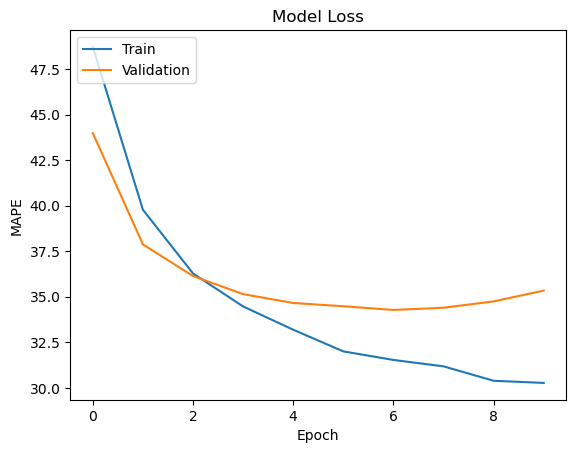

In [28]:


# builds and trains a Multi-Layer Perceptron (MLP) neural network using the Keras API with TensorFlow backend.
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='linear'))
# create Adam optimizer with a learning rate of 0.001
adam = Adam(learning_rate=0.0001)

# compile model with Adam optimizer and a learning rate of 0.001
#model.compile(loss='mean_squared_error', optimizer=adam)
# Compile the model with a loss function and optimizer
#model.compile(loss='mean_squared_error, optimizer=Adam(lr=0.001) )
model.compile(loss=smape_loss, optimizer='adam')
# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 10, verbose=0, batch_size=32)
# Generate generalization metrics

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

# plot training and validation loss over epochs
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Submission 

In [29]:
# May 2nd
import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
amp_pd_peptide.make_env.func_dict['__called__'] = False
iter_test = env.iter_test()    # an iterator which loops over the test files
target_list_sub = ['updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                   'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                   'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                   'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months']
                                   
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    Prot_Peptides_df = pd.merge(test_proteins, test_peptides, on = ['visit_id','UniProt'], how = 'left')
    #Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','NPX','Peptide','PeptideAbundance']]
    #df_filtered2 = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select)]
    Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','Peptide','PeptideAbundance']]
    df_filtered2 = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select)]

    # apply log(x+1) transformation to columns
    #df_filtered2[['NPX','PeptideAbundance']] = df_filtered2[['NPX','PeptideAbundance']].apply(lambda x: np.log1p(x))
    df_filtered2[['PeptideAbundance']] = df_filtered2[['PeptideAbundance']].apply(lambda x: np.log1p(x))
    # standardization
    #scaler1 = StandardScaler()
    df_filtered2[['PeptideAbundance']] = scaler1.fit_transform(df_filtered2[['PeptideAbundance']])

    pca_features_list2 = []
    all_peptides2 = df_filtered2['Peptide'].unique()
    for visit_id in df_filtered2['visit_id'].unique():
        # Part 1: construct UniProt-Peptide Network for each visit_id
        p_df = df_filtered2[df_filtered2['visit_id'] == visit_id]
        # first, pivot the data so that the UniProt column becomes the index, 
        # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
        pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
        # iterate over each UniProt and add missing peptides as columns with a value of 0
        for prot in pivoted.index:
            missing_peptides = set(all_peptides2) - set(pivoted.columns)
            for pep in missing_peptides:
                pivoted.loc[prot, pep] = 0

        # fill any remaining missing values with 0
        pivoted.fillna(0, inplace=True)
        # reset the index so that UniProt is a column again
        pivoted = pivoted.reset_index()
        # rename the index column to 'UniProt'
        pivoted.index.name = 'UniProt'
        # save the pivoted DataFrame to a new variable called `new_df`
        new_df = pivoted.copy(deep=True)

        # Part II: PCA feature extraction
        # fit and transform the data
        df1_pca = pca.fit_transform(new_df.iloc[:,1:])
        # flatten the array to one dimension
        df1_pca = np.array(df1_pca).flatten()
        # store the PCA features along with the visit_id in the list
        pca_features_list2.append({'visit_id': visit_id, 'pca_features': df1_pca})

    # construct a dataframe from the PCA features list
    df_pca_features2 = pd.DataFrame(pca_features_list2)
    # split the pca_features column into multiple columns
    PP_features2 = pd.concat([df_pca_features2.drop('pca_features', axis=1), df_pca_features2['pca_features'].apply(pd.Series)], axis=1)
    # Featureset = Protein-Peptide network informaion + NPX 
    #PP_features22 = pd.merge(PP_features2, df_NPX2, left_on='visit_id', right_index=True, how='left')

    col_fea=PP_features2.columns[1:]
    X_test_sub = scaler_features.transform(PP_features2[col_fea])
    # model.predict(tf.convert_to_tensor(X_test_sub)).astype(int)

    test_result = model.predict(tf.convert_to_tensor(X_test_sub)).astype(int)
    # Create a new DataFrame with the visit_id and predicted target variables
    result_df = pd.DataFrame({'visit_id': PP_features2['visit_id']})
    for i in range(16):
        result_df[target_list_sub[i]]=test_result[:,i]

    ###########

    # Create a new DataFrame to store the predictions
    predictions = pd.DataFrame()

    # Generate a prediction_id for each combination of visit_id and column name
    for col in result_df.columns[1:]:
        predictions = predictions.append(result_df[['visit_id', col]].rename(columns={col: 'rating'}).assign(prediction_id=lambda x: x['visit_id'] + '_' + col))

    for i, row in predictions.iterrows():
        prediction_id = row['prediction_id']
        rating = row['rating']
        sample_submission.loc[sample_submission['prediction_id'] == prediction_id, 'rating'] = rating

    env.predict(sample_submission[['prediction_id', 'rating']])   # register your predictions



This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 34ms/step
